In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [2]:
log_file = "../../backtests/newest.log"
trader_data, products_data, activities, trades = process_log(log_file)

In [3]:
sb1 = products_data["SYNTHETIC_BASKET1"]
sb1_buy_spread = sb1["buy_spread"]
sb1_sell_spread = sb1["sell_spread"]
sb1_zscore_buy = sb1["z_score_buy"]
sb1_zscore_sell = sb1["z_score_sell"]

In [4]:
crois = activities[activities["product"] == "CROISSANTS"].reset_index(drop=True)
jams = activities[activities["product"] == "JAMS"].reset_index(drop=True)
djem = activities[activities["product"] == "DJEMBES"].reset_index(drop=True)
pb1 = activities[activities["product"] == "PICNIC_BASKET1"].reset_index(drop=True)
pb2 = activities[activities["product"] == "PICNIC_BASKET2"].reset_index(drop=True)

cro_ask = crois["ask_price_1"]
cro_bid = crois["bid_price_1"]

jams_ask = jams["ask_price_1"]
jams_bid = jams["bid_price_1"]

dje_ask = djem["ask_price_1"]
dje_bid = djem["bid_price_1"]

pb1_ask = pb1["ask_price_1"]
pb1_bid = pb1["bid_price_1"]

pb2_ask = pb2["ask_price_1"]
pb2_bid = pb2["bid_price_1"]

In [5]:
syn_bid = 6 * cro_bid + 3 * jams_bid + dje_bid
syn_ask = 6 * cro_ask + 3 * jams_ask + dje_ask

spread_buy = pb1_ask - syn_bid
spread_sell = pb1_bid - syn_ask

z_score_buy = (spread_buy - spread_buy.mean()) / spread_buy.std()
z_score_sell = (spread_sell - spread_sell.mean()) / spread_sell.std()

In [6]:
class WelfordStatsWithPriors:
    def __init__(self, initial_mean=None, initial_variance=None, initial_count=10):
        self.n = initial_count if initial_mean is not None else 0
        self.mean = initial_mean if initial_mean is not None else 0.0
        self.M2 = initial_variance * initial_count if initial_variance is not None else 0.0
        
    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        
    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.M2 / self.n if self.n > 1 else 1.0)
    
N = 10
BUY_MEAN = 59.36
BUY_VAR = 7246.50
SELL_MEAN = 36.72
SELL_VAR = 7250.25

buy_stats = WelfordStatsWithPriors(initial_mean=BUY_MEAN, initial_variance=BUY_VAR, initial_count=N)
sell_stats = WelfordStatsWithPriors(initial_mean=SELL_MEAN, initial_variance=SELL_VAR, initial_count=N)

z_scores_buy_est = []
z_scores_sell_est = []

# Process the data
for i in range(len(spread_buy)):
    # Update statistics
    buy_stats.update(spread_buy[i])
    sell_stats.update(spread_sell[i])
    
    z_buy = (spread_buy[i] - buy_stats.get_mean()) / buy_stats.get_std()
    z_sell = (spread_sell[i] - sell_stats.get_mean()) / sell_stats.get_std()
    z_scores_buy_est.append(z_buy)
    z_scores_sell_est.append(z_sell)

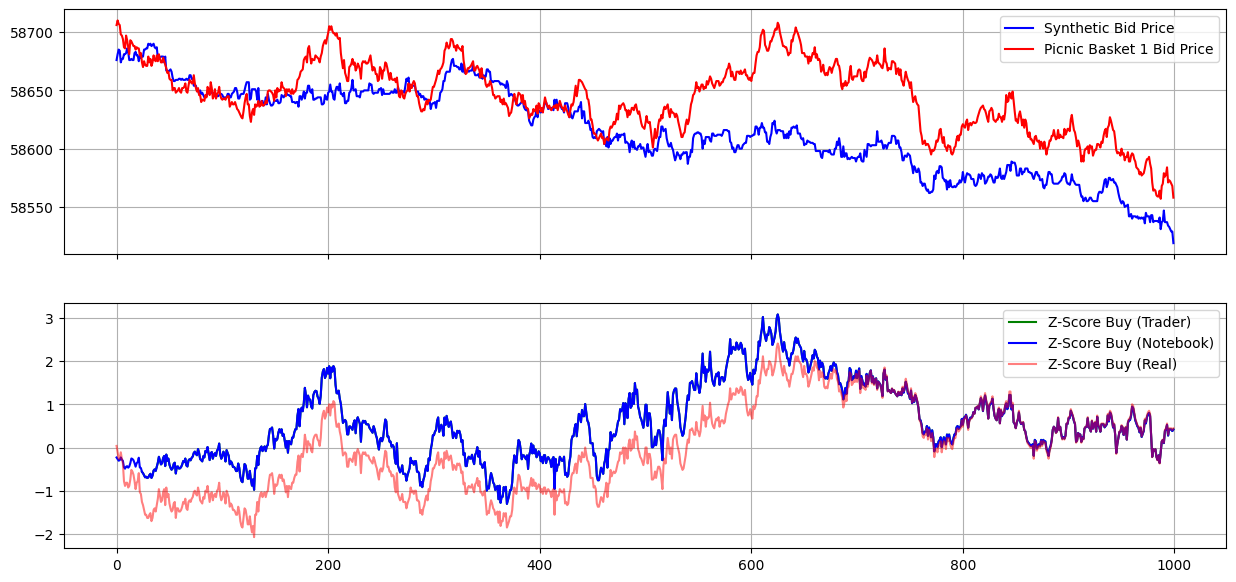

In [7]:

fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
axs[0].plot(syn_bid, label="Synthetic Bid Price", color="blue")
axs[0].plot(pb1_bid, label="Picnic Basket 1 Bid Price", color="red")
axs[0].grid()
axs[0].legend()

axs[1].plot(sb1_zscore_buy, label="Z-Score Buy (Trader)", color="green")
axs[1].plot(z_scores_buy_est, label="Z-Score Buy (Notebook)", color="blue")
axs[1].plot(z_score_buy, label="Z-Score Buy (Real)", color="red", alpha=0.5)
axs[1].grid()
axs[1].legend()

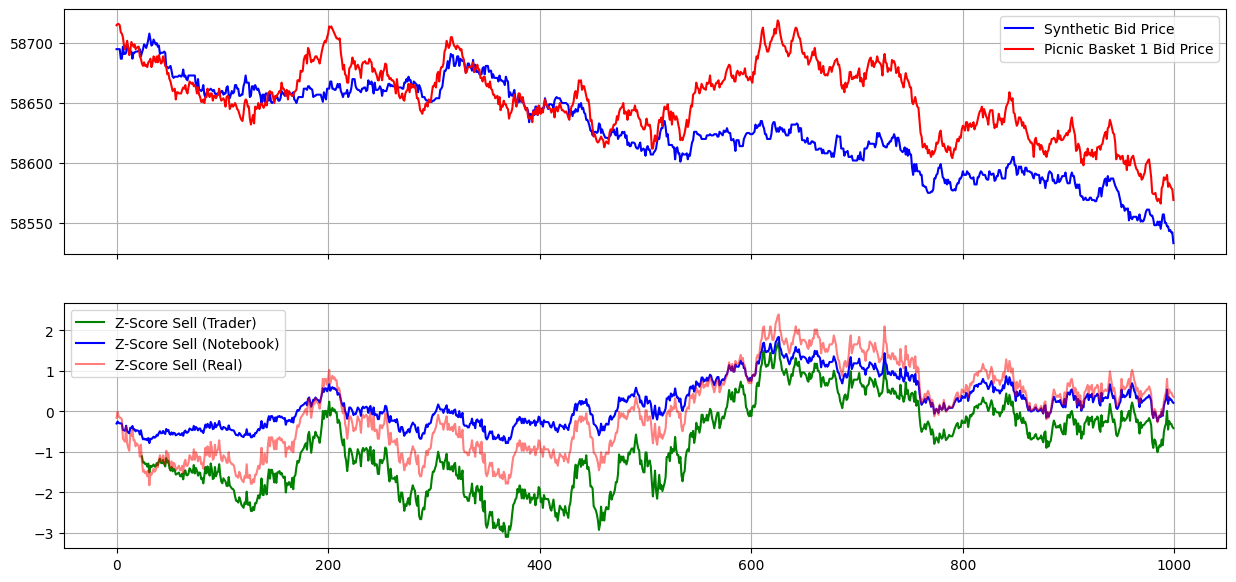

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
axs[0].plot(syn_ask, label="Synthetic Bid Price", color="blue")
axs[0].plot(pb1_ask, label="Picnic Basket 1 Bid Price", color="red")
axs[0].grid()
axs[0].legend()

axs[1].plot(sb1_zscore_sell, label="Z-Score Sell (Trader)", color="green")
axs[1].plot(z_scores_sell_est, label="Z-Score Sell (Notebook)", color="blue")
axs[1].plot(z_score_sell, label="Z-Score Sell (Real)", color="red", alpha=0.5)
axs[1].grid()
axs[1].legend()